In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
plt.rcParams['figure.dpi'] = 150

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
Data_names = []
for (dir_path, dir_names, file_names) in os.walk('./Labday_2_measurements_2'):
    Data_names.extend(file_names)
    
Data_list = []
increasing_segments = []
Increasing_V2 = []
    

In [4]:
Increasing_V2 = []



for i, Data_name in enumerate(Data_names):
    Data = np.loadtxt('Labday_2_measurements_2/' + Data_name, skiprows=3)
    time = Data[:, 0]
    V1 = Data[:, 1]  # Assuming V1 is in the second column
    V2 = Data[:, 2]  # Assuming V2 is in the third column
    
    # Manually specified indices
    a = 5270  # Specify the start index
    b = 8909  # Specify the end index
    c = b-1500
    d = 11000 
    # Collect data between indices a and b
    time_segment = time[a:b+1]
    V1_segment = V1[a:b+1]
    V2_segment = V2[a:b+1]
    
    time_neg = time[c:d]
    V1_Neg_segment = V1[c:d]
    V2_Neg_segment = V2[c:d]
    
    
    # Check if this segment index matches any of the desired indices
    if i in [0, 3, 7, 21, 30, 33, 37, 51]:
        Increasing_V2.append((time_segment, V1_segment, V2_segment))



c_light = const.c
eps0 = const.epsilon_0
a = (1/4)*c_light*eps0
b = (2*np.pi)/(633e-9) 

uncertainty = np.full(len(V1_segment) , 0.05)

print(uncertainty)

[0.05 0.05 0.05 ... 0.05 0.05 0.05]


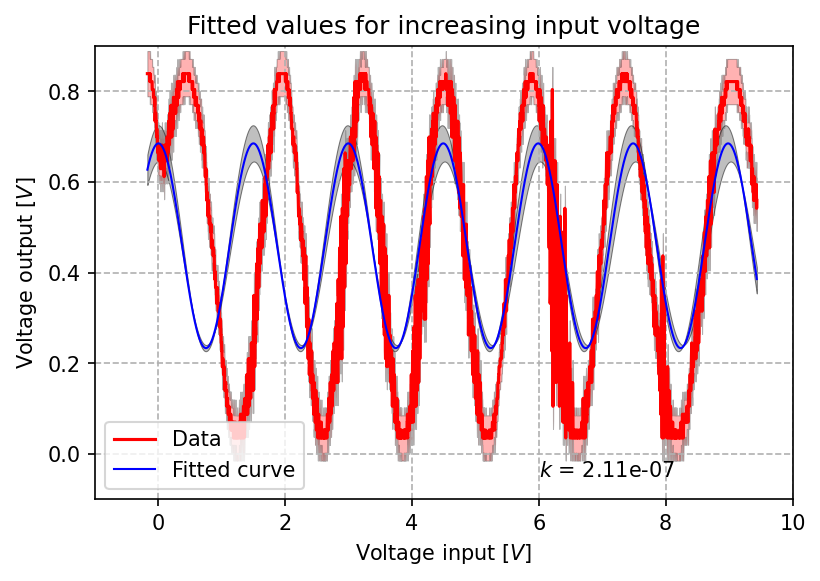

Fitted Parameters:
Amplitude: 0.2259591051390246 $\pm$ 0.001171345522805492
k: 2.1139490820993376e-07 $\pm$ 4.7832522716812003e-11
Offset: 0.45923715181077235 $\pm$ 0.0008302490618641106



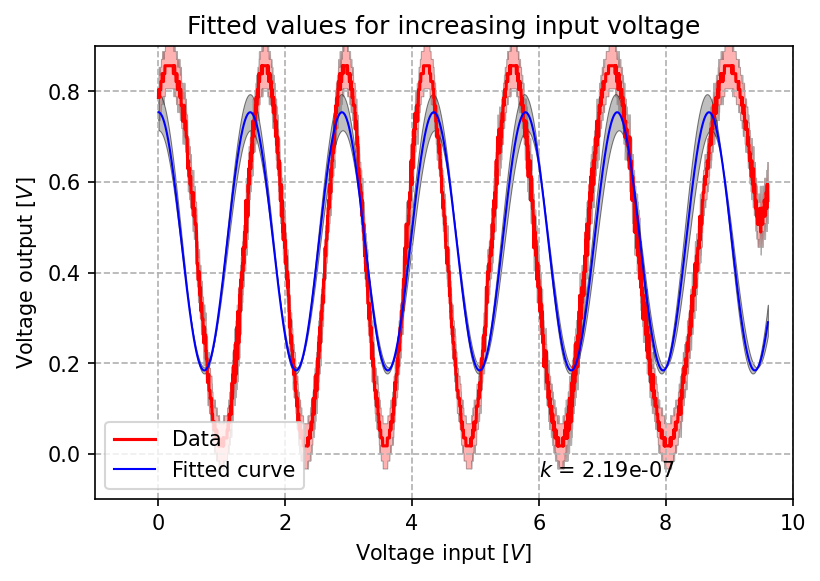

Fitted Parameters:
Amplitude: 0.2850028783235714 $\pm$ 0.0011655800062692048
k: 2.1872965062031434e-07 $\pm$ 3.802017374070705e-11
Offset: 0.46896983909811524 $\pm$ 0.000829569308903479



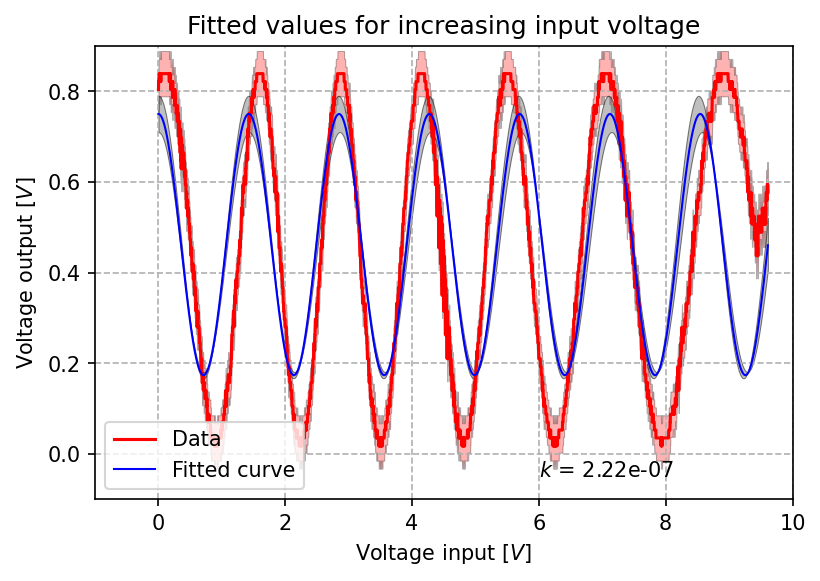

Fitted Parameters:
Amplitude: 0.2882617791529014 $\pm$ 0.001172830683717681
k: 2.2225128120043757e-07 $\pm$ 3.6897538993780504e-11
Offset: 0.4618812109410794 $\pm$ 0.0008291977064325522



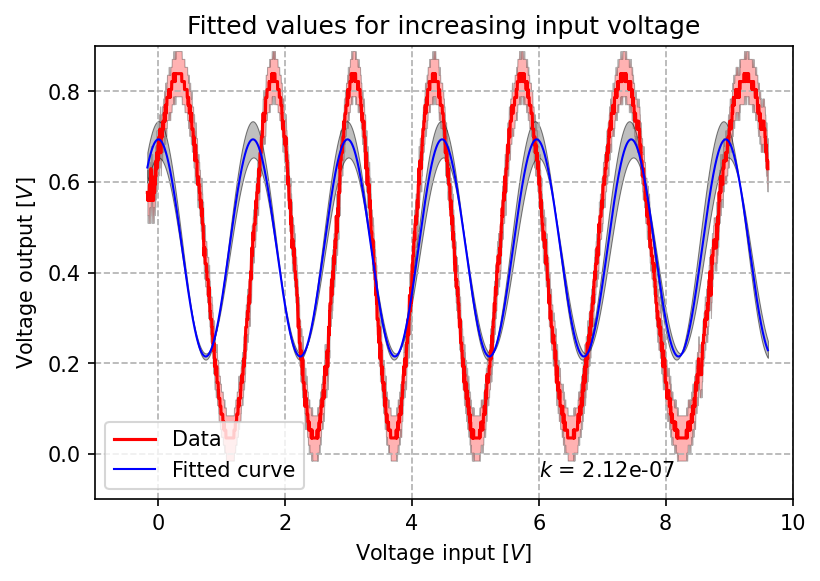

Fitted Parameters:
Amplitude: 0.23969886759694373 $\pm$ 0.001170275915395761
k: 2.122494468017913e-07 $\pm$ 4.4369054929258404e-11
Offset: 0.4544237222115467 $\pm$ 0.0008305938199224041

Overall Standard Deviation:
Amplitude: 0.0011700080320470347
k: 4.177982259513949e-11
Offset: 0.0008299024742806364


In [61]:
amplitude_guess = 1.2 #1.2
k_guess = 21e-8 #21.5e-8
offset_guess = 0.4
p0 = [amplitude_guess, k_guess, offset_guess]

frequency = (2*np.pi)/(633e-9)
def Intensity_fit(v, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    return amplitude *(np.cos(frequency*2*k*v)) + offset

# Placeholder to store standard deviations
perr_all = []
f = 20 #Factor to shade in between for uncertainty

k_inc_val = []
K_inc_unc =[]

# Plot V2 vs. V1 and V1_segment vs. time_segment for each segment of increasing V2 on individual plots
for i, segment in enumerate(Increasing_V2):
    time_segment, V1_segment, V2_segment = segment
    
    V2_help = np.linspace(min(V2_segment), max(V2_segment), len(V1_segment))
    # Perform curve fitting
    popt, pcov = sp.curve_fit(Intensity_fit, V2_help, V1_segment, p0=p0, absolute_sigma = True, sigma = uncertainty)

    # Calculate the standard deviations of the fitted parameters
    perr = np.sqrt(np.diag(pcov))
    perr_all.append(perr)
    
    # Plot V2 vs. V1
    plt.plot(V2_help, V1_segment, '-',ms = 2, color = 'red', label='Data')
    plt.fill_between(V2_help, V1_segment - uncertainty, V1_segment + uncertainty, color = 'red', alpha = 0.3, lw = 0.5, edgecolor = 'k')
    plt.plot(V2_help, Intensity_fit(V2_help, *popt), '-',lw=1, color= 'blue', label='Fitted curve', alpha = 1)
    #plt.plot(V2_help, Intensity_fit(V2_help, *p0), '-', label = 'guess')
    plt.fill_between(V2_help, Intensity_fit(V2_help, popt[0] - f*np.sqrt(pcov[0][0]) , popt[1] - f*np.sqrt(pcov[1][1]), popt[2] - f*np.sqrt(pcov[2][2])),
                     Intensity_fit(V2_help, popt[0] + f*np.sqrt(pcov[0][0]) , popt[1] + f*np.sqrt(pcov[1][1]), popt[2] + f*np.sqrt(pcov[2][2])),
                     color = 'grey', alpha = 0.5, lw = 0.5, edgecolor = 'k')
    plt.text(6, -0.05, f'$k$ = {popt[1]:.03g}')
    plt.axis([-1, 10, -0.1, 0.9])
    plt.xlabel('Voltage input [$V$]')
    plt.ylabel('Voltage output [$V$]')
    plt.title('Fitted values for increasing input voltage')
    plt.legend(loc = 'lower left')
    plt.grid(ls = '--')
    plt.show()
    
    print("Fitted Parameters:")
    print("Amplitude:", popt[0], '$\pm$', perr[0])
    print("k:", popt[1], '$\pm$', perr[1])
    k_inc_val.append(popt[1])
    K_inc_unc.append(perr[1])
    print("Offset:", popt[2], '$\pm$', perr[2])
    print()

# Print overall standard deviation
print("Overall Standard Deviation:")
print("Amplitude:", np.mean(perr_all, axis=0)[0])
print("k:", np.mean(perr_all, axis=0)[1])
print("Offset:", np.mean(perr_all, axis=0)[2])



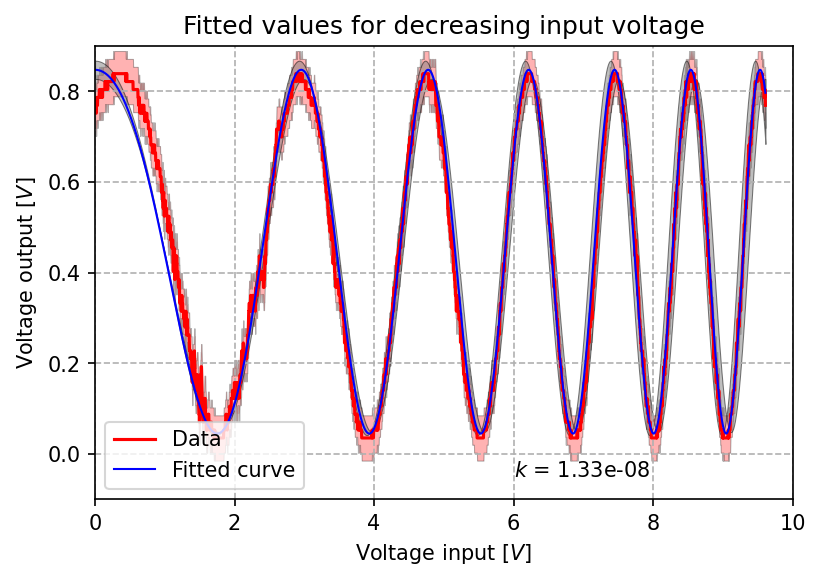

Fitted Parameters:
Amplitude: 0.4015195478040297 +/- 0.0011736525297605118
k: 1.3269249522727743e-08 +/- 1.3845902554222949e-11
Offset: 0.4461400877379436 +/- 0.0008371696004382031
n: 6.227326885813221e-08 +/- 1.022921259901486e-10


In [44]:
amplitude_guess = 2
k_guess = 21e-9
offset_guess = 0.4
n_guess = 0
p0_NEG = [amplitude_guess, k_guess, offset_guess, n_guess]

frequency = (2*np.pi)/(600e-9)

Neg_uncertainty = np.full(len(V1_Neg_segment), 0.05)

nf = 10

def Intensity_Quad_fit(v, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    n = p[3]
    return amplitude *(np.cos(frequency*2*(k*v**2+n*v))) + offset

V2_Neg_help = np.linspace(min(V2_Neg_segment), max(V2_Neg_segment), len(V1_Neg_segment))

# Perform curve fitting
popt_NEG, pcov_NEG = sp.curve_fit(Intensity_Quad_fit, V2_Neg_help, V1_Neg_segment, p0=p0_NEG, absolute_sigma = True, sigma = Neg_uncertainty)

# Calculate the standard deviations of the fitted parameters
perr_NEG = np.sqrt(np.diag(pcov_NEG))

#plt.plot(V2_help, Intensity_fit(V2_help, *popt), '-',lw=1, color= 'blue', label='Fitted curve', alpha = 1)
# Plot V2 vs. V1
plt.plot(V2_Neg_help, V1_Neg_segment, '-', ms =2, color = 'red', label='Data')
plt.fill_between(V2_Neg_help, V1_Neg_segment - Neg_uncertainty, V1_Neg_segment + Neg_uncertainty, color = 'red', alpha = 0.3, lw = 0.5, edgecolor = 'k')
#plt.plot(V2_Neg_help, Intensity_Quad_fit(V2_Neg_help, *p0_NEG), label='Guess')
plt.plot(V2_Neg_help, Intensity_Quad_fit(V2_Neg_help, *popt_NEG), '-', lw = 1, color = 'blue', label='Fitted curve')
plt.fill_between(V2_Neg_help, Intensity_Quad_fit(V2_Neg_help, popt_NEG[0] - nf*np.sqrt(pcov_NEG[0][0]) , popt_NEG[1] - nf*np.sqrt(pcov_NEG[1][1]),
                                                 popt_NEG[2] - nf*np.sqrt(pcov_NEG[2][2]), popt_NEG[3] - nf*np.sqrt(pcov_NEG[3][3])),
                     Intensity_Quad_fit(V2_Neg_help, popt_NEG[0] + nf*np.sqrt(pcov_NEG[0][0]) , popt_NEG[1] + nf*np.sqrt(pcov_NEG[1][1]),
                                        popt_NEG[2] + nf*np.sqrt(pcov_NEG[2][2]), popt_NEG[3] + nf*np.sqrt(pcov_NEG[3][3])),
                     color = 'grey', alpha = 0.5, lw = 0.5, edgecolor = 'k')

plt.text(6, -0.05, f'$k$ = {popt_NEG[1]:.03g}')
plt.axis([0, 10, -0.1, 0.9])
plt.xlabel('Voltage input [$V$]')
plt.ylabel('Voltage output [$V$]')
plt.title('Fitted values for decreasing input voltage')
plt.legend(loc = 3)
plt.grid(ls = '--')
plt.show()

# Print fitted parameters and their standard deviations
print("Fitted Parameters:")
print("Amplitude:", popt_NEG[0], "+/-", perr_NEG[0])
print("k:", popt_NEG[1], "+/-", perr_NEG[1])
print("Offset:", popt_NEG[2], "+/-", perr_NEG[2])
print("n:", popt_NEG[3], "+/-", perr_NEG[3])

[5.242372 5.242372 5.242372 ... 6.116511 6.116511 6.116511]
[1599]
[4.718258 4.718258 4.718258 ... 5.591782 5.591782 5.591782]
[1599, 1838]
[2.097072 2.097072 2.097072 ... 3.1453   3.1453   3.1453  ]
[1599, 1838, 2765]
[5.591782 5.591782 5.591782 ... 6.46592  6.46592  6.46592 ]
[1599, 1838, 2765, 1451]
[9.087107 9.087107 9.087107 ... 9.436516 9.436516 9.436516]
[1599, 1838, 2765, 1451, 14899]
[9.61122  9.61122  9.61122  ... 8.737697 8.737697 8.737697]
[1599, 1838, 2765, 1451, 14899, 0]
[9.61122  9.61122  9.61122  ... 8.737697 8.737697 8.912401]
[1599, 1838, 2765, 1451, 14899, 0, 0]
[5.591782 5.591782 5.766486 ... 6.640625 6.640625 6.640625]
[1599, 1838, 2765, 1451, 14899, 0, 0, 1438]
[1.397638 1.397638 1.397638 ... 2.271777 2.271777 2.271777]
[1599, 1838, 2765, 1451, 14899, 0, 0, 1438, 3034]
[5.766486 5.591782 5.766486 ... 4.892962 4.892962 4.892962]
[1599, 1838, 2765, 1451, 14899, 0, 0, 1438, 3034, 5808]
[1.921752  1.921752  1.921752  ... 0.8735236 0.8735236 0.8735236]
[1599, 1838, 27

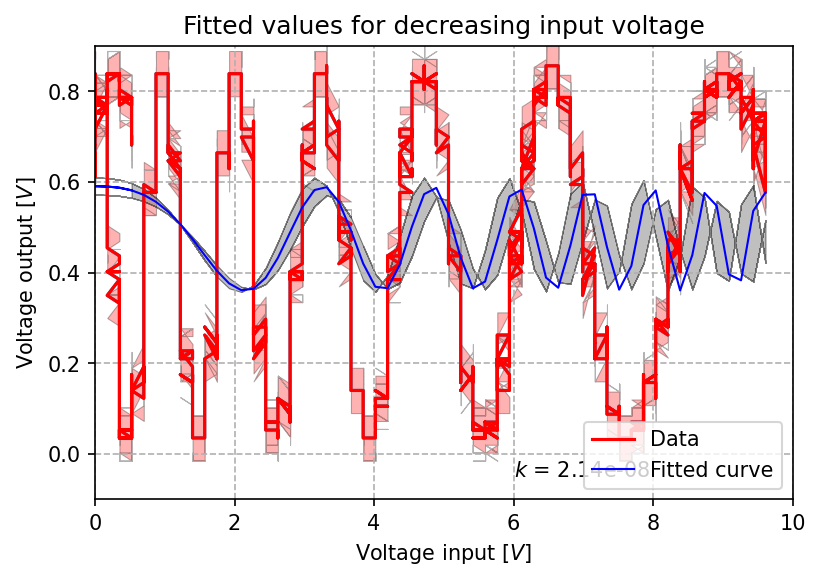

Fitted Parameters:
Amplitude: 0.11537656987620348 +/- 0.0010840050546276642
k: 2.144013115835919e-08 +/- 4.842499439297149e-11
Offset: 0.47523915593745225 +/- 0.000806872421507191
n: 2.7044181351792065e-08 +/- 3.6369602092973607e-10
Length of V1:  4000 Length of V2: 4000
[9.61122   9.436516  9.61122   ... 0.6988189 0.5241142 0.5241142]


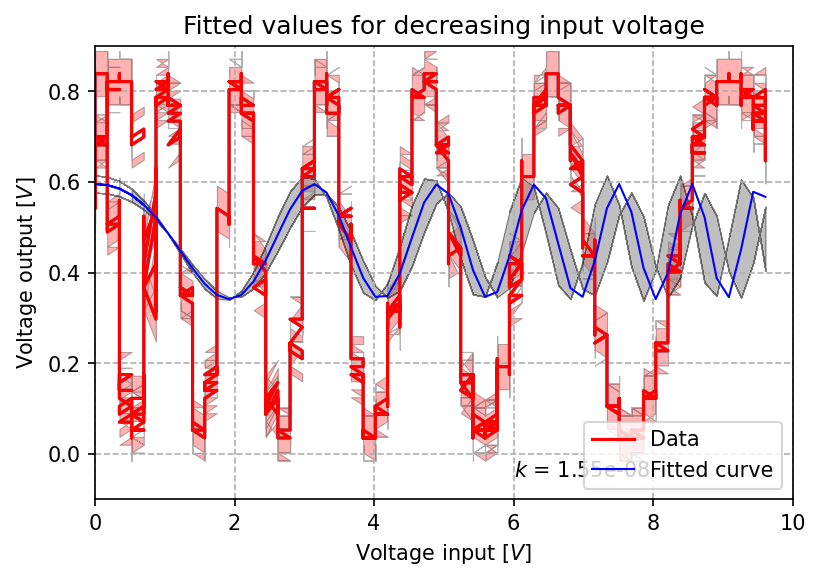

Fitted Parameters:
Amplitude: 0.12710139428205539 +/- 0.0010937945361330066
k: 1.548340417792045e-08 +/- 4.3842921098042603e-11
Offset: 0.46833190920848145 +/- 0.0008021639921650678
n: 5.2331480839107665e-08 +/- 3.297427026441833e-10
Length of V1:  4000 Length of V2: 4000
[9.61122   9.436516  9.436516  ... 0.5241142 0.5241142 0.6988189]


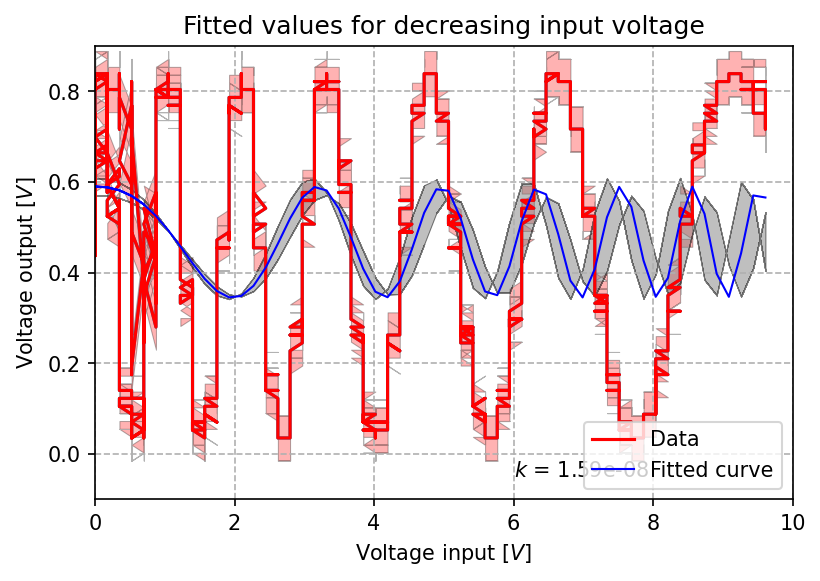

Fitted Parameters:
Amplitude: 0.12292957254292942 +/- 0.001088991247427835
k: 1.586706285196712e-08 +/- 4.5600490120951404e-11
Offset: 0.467176744630123 +/- 0.0008029195292017273
n: 4.843640092093543e-08 +/- 3.422976349289265e-10
Length of V1:  4000 Length of V2: 4000
[9.61122   9.436516  9.436516  ... 0.5241142 0.5241142 0.5241142]


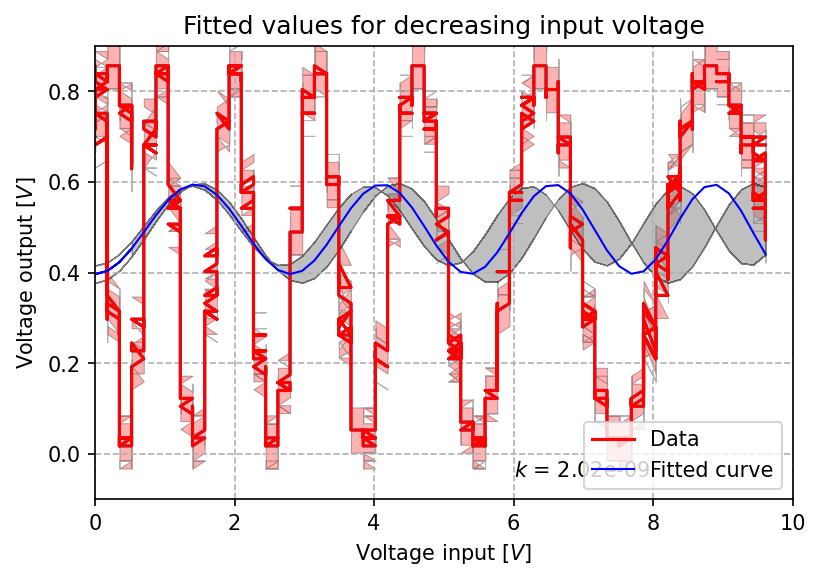

Fitted Parameters:
Amplitude: -0.0990772820892153 +/- 0.0011119895687588502
k: 2.0236913325705796e-09 +/- 5.288674874995723e-11
Offset: 0.49565374596287065 +/- 0.0008011566394896109
n: 1.0708839747876118e-07 +/- 4.087646163130397e-10
Length of V1:  4000 Length of V2: 4000
[5.591782 5.591782 5.766486 ... 2.970595 2.970595 2.970595]


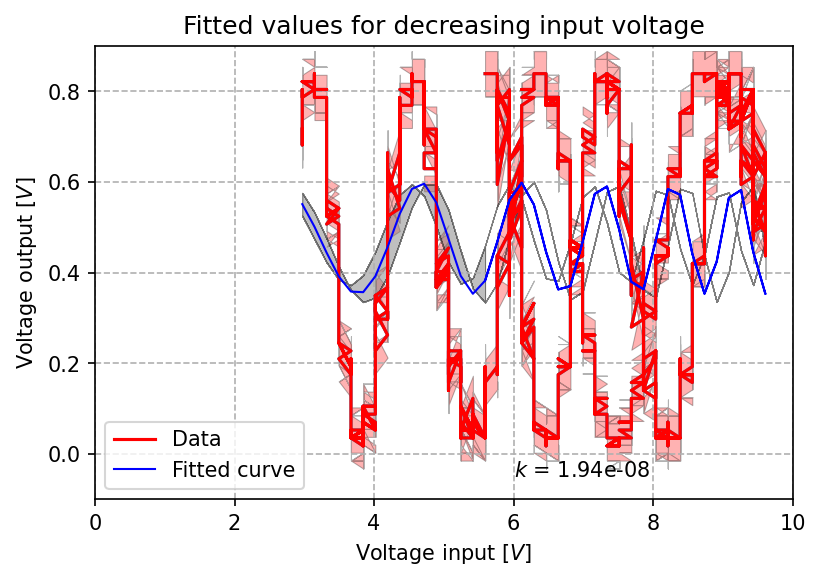

Fitted Parameters:
Amplitude: -0.1227738724019115 +/- 0.0011260119497195449
k: 1.9407570906383735e-08 +/- 4.380286857492974e-11
Offset: 0.47562692905541903 +/- 0.0007923473756518028
n: 1.1028759993247234e-08 +/- 3.397025663137995e-10
Length of V1:  4000 Length of V2: 4000
[1.397638 1.397638 1.397638 ... 7.164739 7.164739 7.164739]


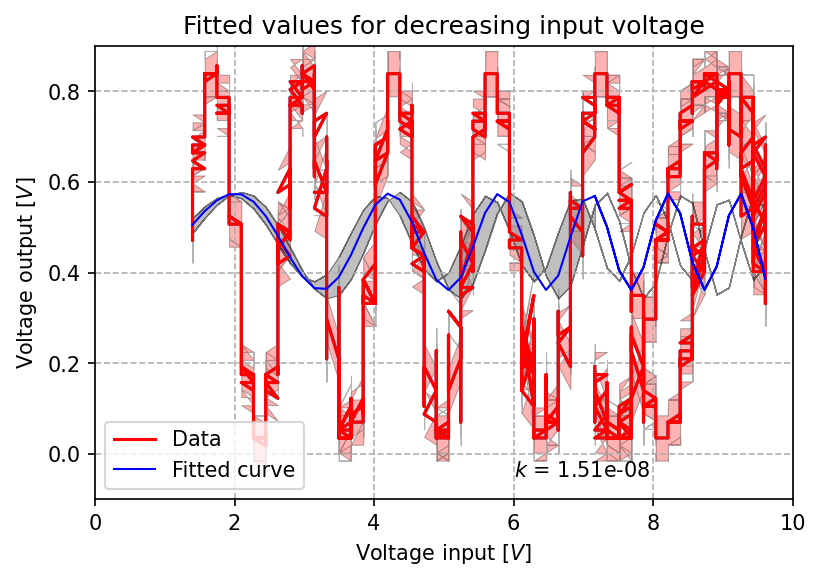

Fitted Parameters:
Amplitude: -0.10669656559030018 +/- 0.0011202351506042654
k: 1.513898205021832e-08 +/- 4.8153104351358e-11
Offset: 0.4681388914982899 +/- 0.0007954157177355109
n: 4.845653909581592e-08 +/- 3.8269555095176824e-10
Length of V1:  4000 Length of V2: 4000
[1.921752 1.921752 1.921752 ... 8.562992 8.562992 8.562992]


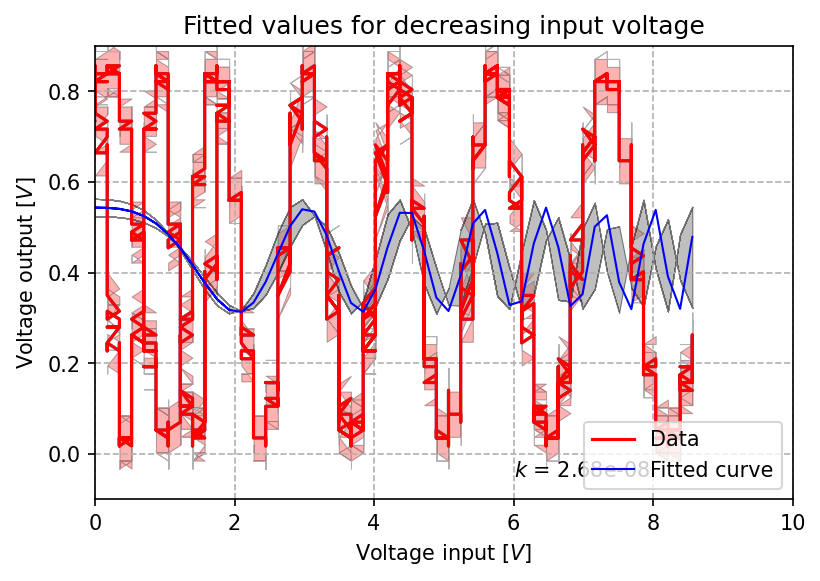

Fitted Parameters:
Amplitude: 0.11573825281202903 +/- 0.001101725823821252
k: 2.681412267297617e-08 +/- 6.395793774274838e-11
Offset: 0.42771758287023215 +/- 0.0008199865619470033
n: 2.256588309320944e-08 +/- 4.2072785180662475e-10
Length of V1:  4000 Length of V2: 4000
[5.941191 6.116511 6.116511 ... 2.621186 2.621186 2.621186]


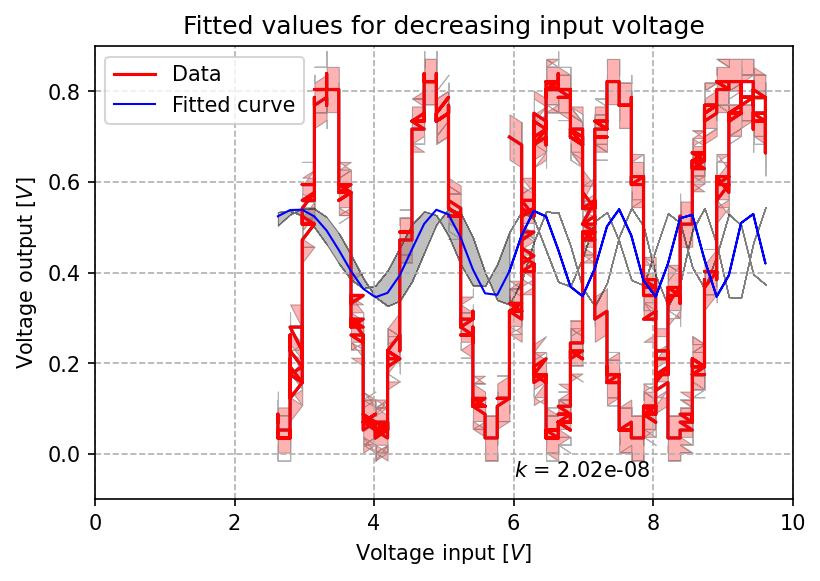

Fitted Parameters:
Amplitude: -0.09765192302661063 +/- 0.0011208874398582695
k: 2.0224885845360994e-08 +/- 5.4458194439974624e-11
Offset: 0.4427021552532155 +/- 0.0007954983222174605
n: -3.823190446950177e-09 +/- 4.290953696576681e-10
Length of V1:  4000 Length of V2: 4000
[2.621186 2.621186 2.621186 ... 7.863558 7.863558 7.863558]


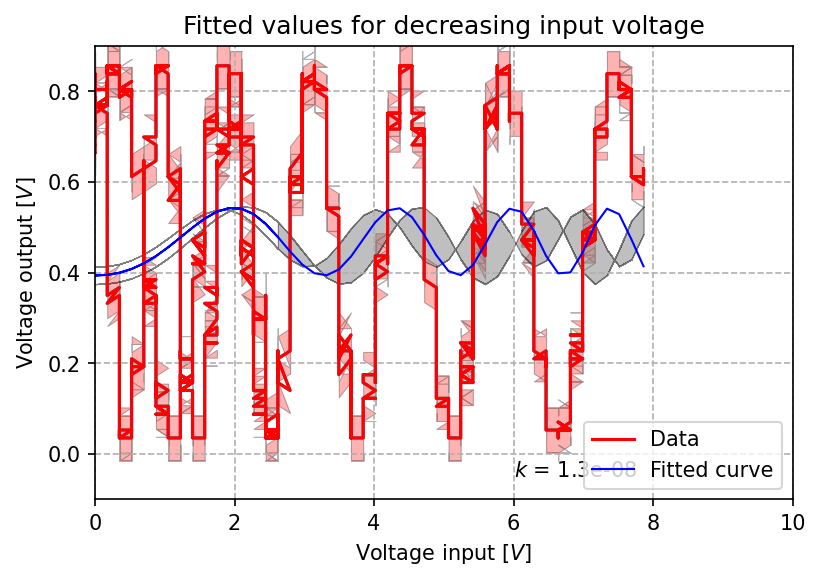

Fitted Parameters:
Amplitude: -0.07476168388922143 +/- 0.00109956987500688
k: 1.301749583546557e-08 +/- 1.1400238647514531e-10
Offset: 0.4683298792317953 +/- 0.0007973592565575382
n: 5.379824650537216e-08 +/- 6.833021844750223e-10
Length of V1:  4000 Length of V2: 4000
[9.087107  9.087107  9.087107  ... 0.1747047 0.1747047 0.1747047]


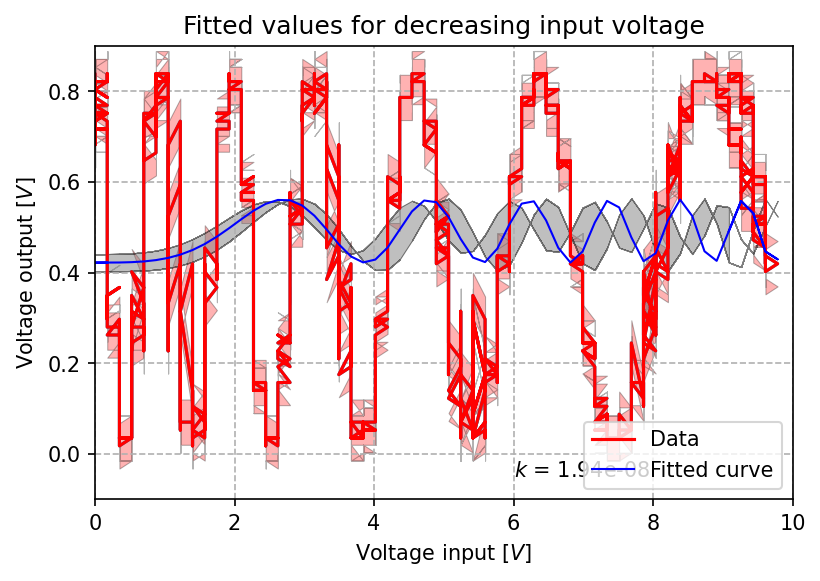

Fitted Parameters:
Amplitude: -0.0696655539227843 +/- 0.001078618262528754
k: 1.9441136946654744e-08 +/- 7.497910547625038e-11
Offset: 0.4916568044546599 +/- 0.0008093198762190923
n: 6.190290278304583e-09 +/- 5.821347773636907e-10
Length of V1:  4000 Length of V2: 4000
[1.747047 1.747047 1.747047 ... 6.81533  6.81533  6.81533 ]


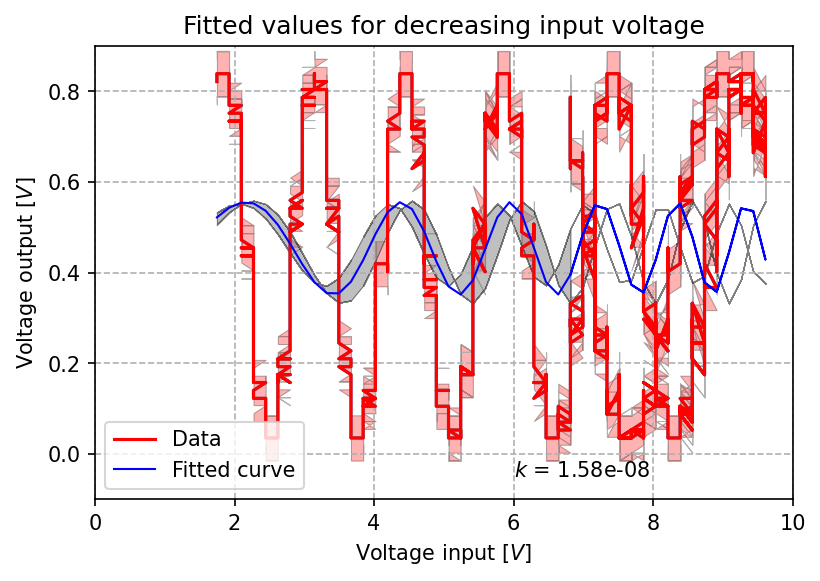

Fitted Parameters:
Amplitude: -0.10221809872713705 +/- 0.0011199798046665115
k: 1.5785536597970957e-08 +/- 5.074197934027536e-11
Offset: 0.4533434716959924 +/- 0.0007950317603243119
n: 3.888925799302438e-08 +/- 4.0193911951647025e-10
Length of V1:  4000 Length of V2: 4000
[1.397638 1.397638 1.572343 ... 7.164739 7.164739 7.164739]


Fitted Parameters:
Amplitude: -0.09829582545677744 +/- 0.001119533404394378
k: 1.5749544067272292e-08 +/- 5.219341832995466e-11
Offset: 0.4569881517564414 +/- 0.0007978158354832875
n: 4.077616114123166e-08 +/- 4.151152322750942e-10
Length of V1:  4000 Length of V2: 4000
[5.242372 5.067667 5.242372 ... 5.242372 5.242372 5.242372]


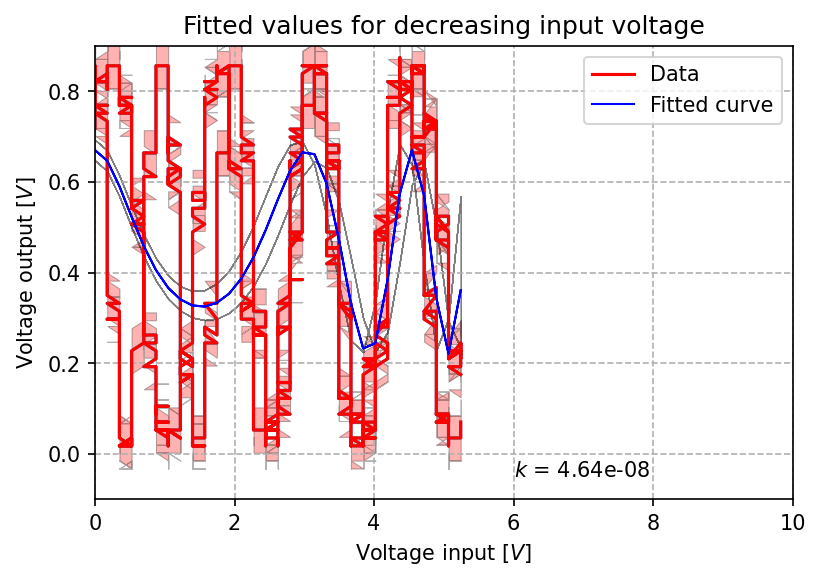

Fitted Parameters:
Amplitude: 0.2245696814215855 +/- 0.0012919066211328693
k: 4.643943496493789e-08 +/- 9.217252168706143e-11
Offset: 0.4457281297096307 +/- 0.0009869619428236494
n: -1.4151748947764988e-07 +/- 3.6641268448503374e-10
Length of V1:  4000 Length of V2: 4000
[9.436516  9.436516  9.436516  ... 0.5241142 0.5241142 0.5241142]


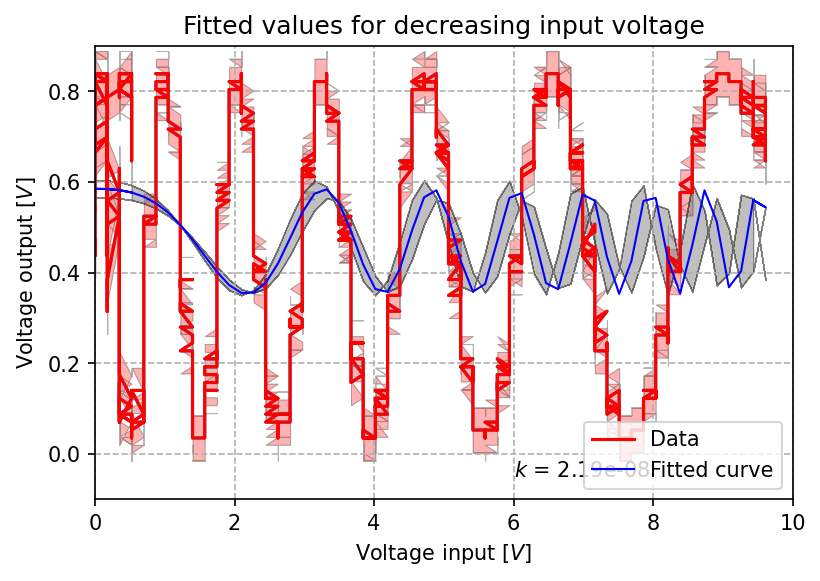

Fitted Parameters:
Amplitude: 0.11605381649420543 +/- 0.001089133775501233
k: 2.1871637959040464e-08 +/- 4.653785538821288e-11
Offset: 0.4689295969450245 +/- 0.0008084229654104606
n: 2.4816796650231192e-08 +/- 3.552759010602913e-10
Length of V1:  4000 Length of V2: 4000
[7.339444 7.339444 7.164739 ... 3.1453   3.1453   3.1453  ]


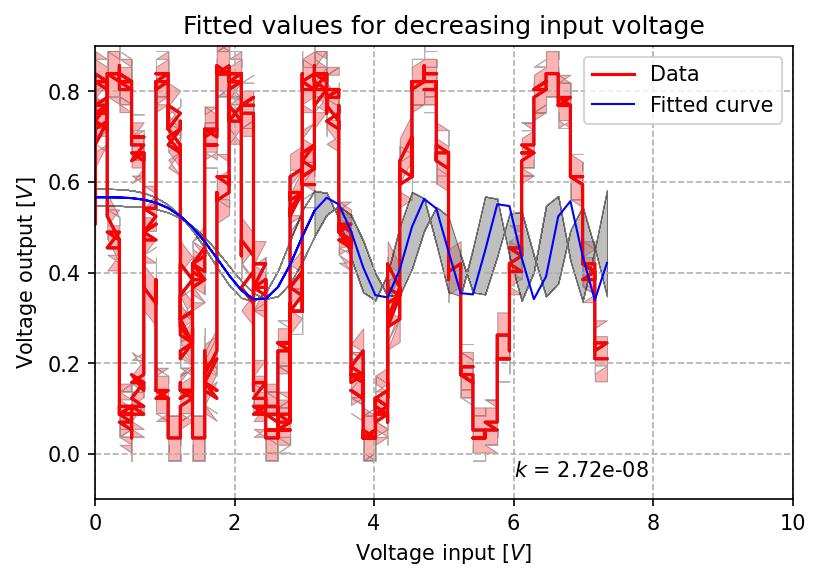

Fitted Parameters:
Amplitude: 0.11373037615726023 +/- 0.0010760321083157385
k: 2.7237926436612392e-08 +/- 8.871447595055467e-11
Offset: 0.452480852796803 +/- 0.0008130060968592892
n: 3.0094682510929167e-09 +/- 4.752045775174993e-10
Length of V1:  4000 Length of V2: 4000
[2.446481 2.446481 2.446481 ... 6.116511 6.116511 6.116511]


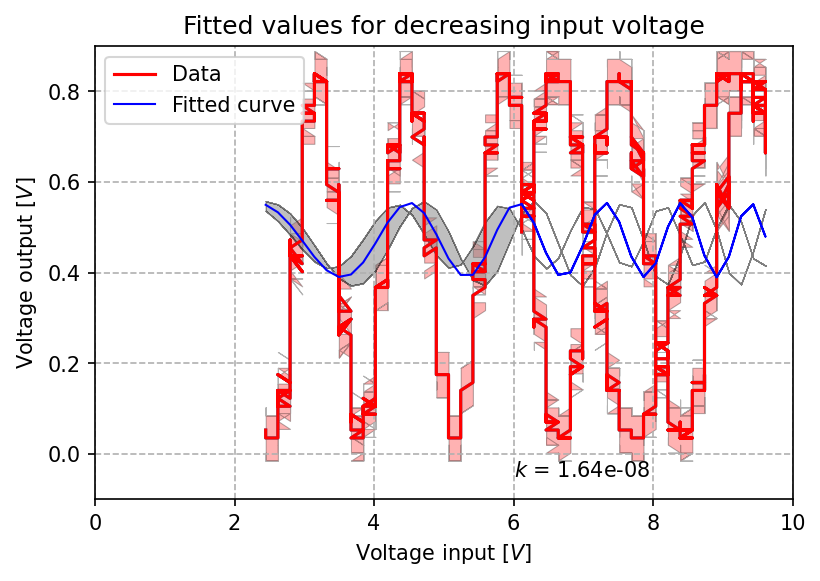

Fitted Parameters:
Amplitude: -0.08223873270285452 +/- 0.0011349111224979189
k: 1.63694172797427e-08 +/- 6.27520075286231e-11
Offset: 0.4719074873296833 +/- 0.0007938940500160312
n: 3.15274593954149e-08 +/- 4.944908885859751e-10
Length of V1:  4000 Length of V2: 4000
[1.921752 1.921752 1.921752 ... 8.562992 8.562992 8.562992]


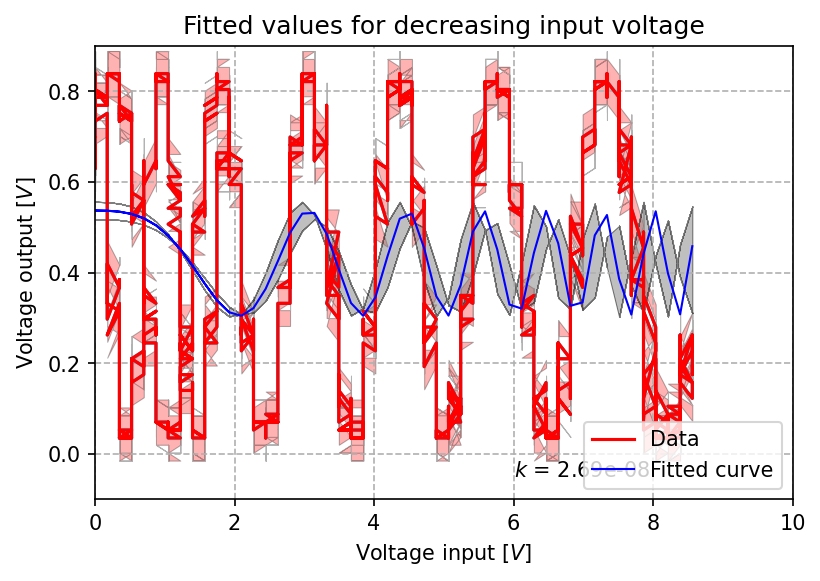

Fitted Parameters:
Amplitude: 0.11631876908753055 +/- 0.0010986334807853537
k: 2.6946185815368193e-08 +/- 6.392441329945019e-11
Offset: 0.4206511857344616 +/- 0.000820785406599192
n: 2.068487592779952e-08 +/- 4.2052906544796345e-10
Length of V1:  4000 Length of V2: 4000
[2.097072 2.097072 2.097072 ... 6.291215 6.46592  6.46592 ]


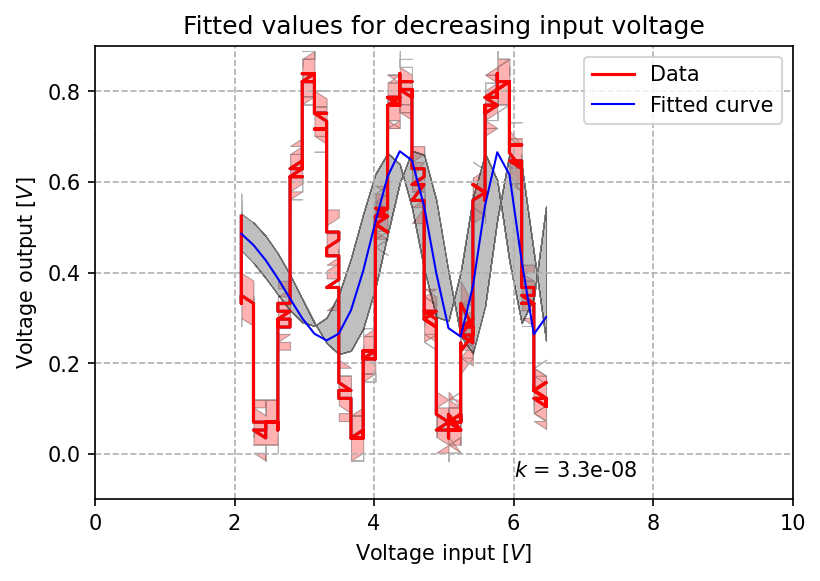

Fitted Parameters:
Amplitude: -0.21028750665790813 +/- 0.0018839931966123944
k: 3.298015942349977e-08 +/- 8.459598230700389e-11
Offset: 0.46047302490320113 +/- 0.0013045226137650915
n: -1.0977798086341526e-07 +/- 4.228639648497376e-10
Length of V1:  1605 Length of V2: 1605
[1.048228 1.048228 1.048228 ... 9.436516 9.436516 9.436516]


Fitted Parameters:
Amplitude: 0.11614545459253335 +/- 0.0011030527503897455
k: 2.1230120100029864e-08 +/- 5.223146039642477e-11
Offset: 0.4457629750828919 +/- 0.0008076857446758633
n: 4.473625253695685e-08 +/- 3.796200498646541e-10
Length of V1:  4000 Length of V2: 4000
[1.222933 1.222933 1.222933 ... 7.339444 7.339444 7.514149]


Fitted Parameters:
Amplitude: -0.1283808081170482 +/- 0.0011425171864757767
k: 1.5993867395867774e-08 +/- 3.950572556759893e-11
Offset: 0.44473009026240856 +/- 0.000794943200037795
n: 3.569938294098048e-08 +/- 3.136858178001813e-10
Length of V1:  4000 Length of V2: 4000
[5.242372 5.242372 5.242372 ... 3.320005 3.320005 3.320005]


Fitted Parameters:
Amplitude: -0.10650475629004721 +/- 0.0011130167147955217
k: 1.815177351523777e-08 +/- 5.1083083565345503e-11
Offset: 0.4777130433544388 +/- 0.0007941733277687372
n: 1.5867626415946302e-08 +/- 4.021695972340486e-10
Length of V1:  4000 Length of V2: 4000
[6.46592  6.46592  6.46592  ... 2.271777 2.271777 2.271777]


Fitted Parameters:
Amplitude: -0.10521439043441402 +/- 0.0011378236531790526
k: 2.6452621719950388e-08 +/- 4.8663054169179394e-11
Offset: 0.4512478383302371 +/- 0.0007929451521755674
n: -3.352656482400797e-08 +/- 3.8395422941178455e-10
Length of V1:  4000 Length of V2: 4000
[8.737697 8.737697 8.737697 ... 0.       0.       0.      ]


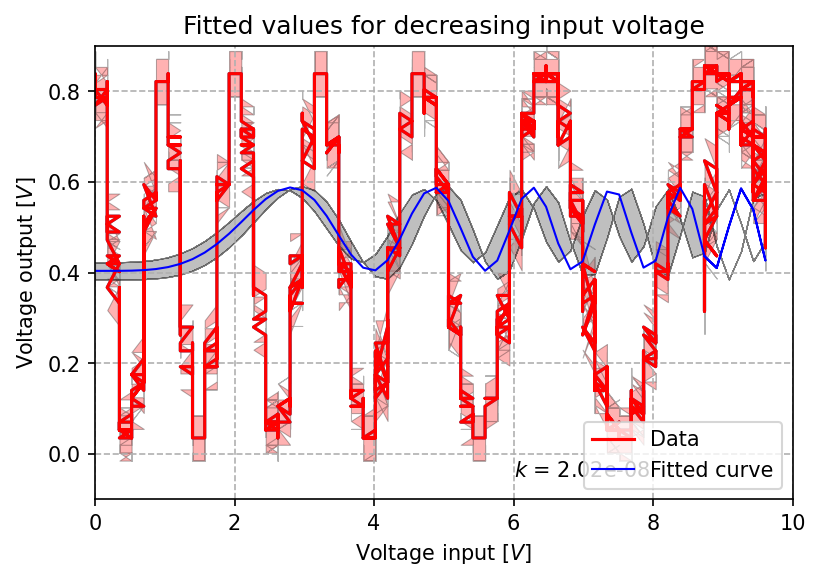

Fitted Parameters:
Amplitude: -0.0920815907075858 +/- 0.0010926472759125315
k: 2.0218260811124087e-08 +/- 5.561106237745382e-11
Offset: 0.49586355931431186 +/- 0.0008061560780426236
n: -5.413370576827661e-10 +/- 4.3711818540845627e-10
Length of V1:  4000 Length of V2: 4000
[9.61122   9.61122   9.61122   ... 0.8735236 0.8735236 0.8735236]


Fitted Parameters:
Amplitude: 0.10855880153890315 +/- 0.001078111911395601
k: 2.3344849034240966e-08 +/- 5.3234066634071894e-11
Offset: 0.45586794847556894 +/- 0.0008133889318261387
n: 1.508641197590282e-08 +/- 3.9442630747213626e-10
Length of V1:  4000 Length of V2: 4000
[5.067667 5.067667 5.067667 ... 5.242372 5.242372 5.242372]


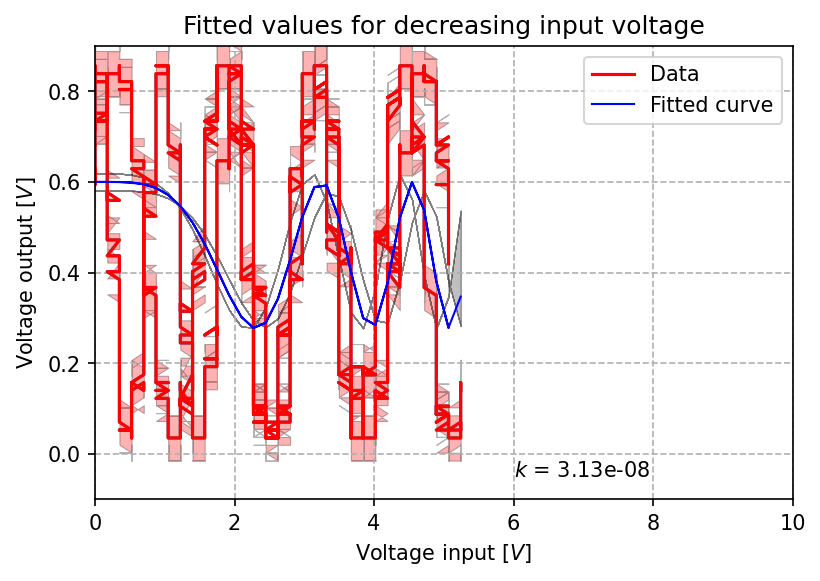

Fitted Parameters:
Amplitude: 0.1615926690076427 +/- 0.0010691809387887395
k: 3.129236996302935e-08 +/- 1.1946745095656954e-10
Offset: 0.43851438849313434 +/- 0.0008297768899557123
n: -3.807604123806065e-09 +/- 4.80194259773301e-10
Length of V1:  4000 Length of V2: 4000
[5.417077 5.417077 5.417077 ... 3.1453   3.1453   3.1453  ]


Fitted Parameters:
Amplitude: -0.116970668614165 +/- 0.0011288390132886345
k: 1.943497099648712e-08 +/- 4.53053904658151e-11
Offset: 0.4762034634621675 +/- 0.0007911115148003519
n: 3.395106944035855e-09 +/- 3.544086831881124e-10
Length of V1:  4000 Length of V2: 4000


In [42]:
time = []
V1 = []
V2 =[]
V1_array =[]
V2_array = []
V2_max =[]
time_max = []
V1_max =[]
V2_N_segment = []
V1_N_segment = []
k_val = []
sigma_k = []


for i, Data_name in enumerate(Data_names):
    Data = np.loadtxt('Labday_2_measurements_2/' + Data_name, skiprows=3)
    time.append(Data[:,0])
    V1.extend(Data[:,1])
    V2.extend(Data[:,2])
    V1_array.append(Data[:,1])
    V2_array.append(Data[:,2])
    
    print(V2_array[i])
    V2_max.append(np.argmax(V2_array[i]))
    print(V2_max)

del time[4]
del V1_array[4]
del V2_array[4]

amplitude_guess = 2
k_guess = 21e-9
offset_guess = 0.4
n_guess = 0
p0_N = [amplitude_guess, k_guess, offset_guess, n_guess]

# Removing the array at index 4
del time[4]
del V1_array[4]
del V2_array[4]
# Adjust loop range to iterate over remaining arrays
for j in range(28):
    # Ensure we skip index 4
    if j == 4 or j == 16:
        continue
    
    a = V2_max[j]
    b = a + 4000
    V2_N_segment = V2_array[j][a:b]
    V1_N_segment = V1_array[j][a:b]
    print(V2_N_segment)
    plt.plot(V2_N_segment, V1_N_segment)
    
    Neg_uncertainty = np.full(len(V1_N_segment), 0.05)

    
    popt_N, pcov_N = sp.curve_fit(Intensity_Quad_fit, V2_N_segment, V1_N_segment, p0=p0_N, absolute_sigma = True, sigma = Neg_uncertainty)

# Calculate the standard deviations of the fitted parameters
    perr_N = np.sqrt(np.diag(pcov_N))

#plt.plot(V2_help, Intensity_fit(V2_help, *popt), '-',lw=1, color= 'blue', label='Fitted curve', alpha = 1)
# Plot V2 vs. V1
    plt.plot(V2_N_segment, V1_N_segment, '-', ms =2, color = 'red', label='Data')
    plt.fill_between(V2_N_segment, V1_N_segment - Neg_uncertainty, V1_N_segment + Neg_uncertainty, color = 'red', alpha = 0.3, lw = 0.5, edgecolor = 'k')
#plt.plot(V2_Neg_help, Intensity_Quad_fit(V2_Neg_help, *p0_NEG), label='Guess')
    plt.plot(V2_N_segment, Intensity_Quad_fit(V2_N_segment, *popt_N), '-', lw = 1, color = 'blue', label='Fitted curve')
    plt.fill_between(V2_N_segment, Intensity_Quad_fit(V2_N_segment, popt_N[0] - nf*np.sqrt(pcov_N[0][0]) , popt_N[1] - nf*np.sqrt(pcov_N[1][1]),
                                                 popt_N[2] - nf*np.sqrt(pcov_N[2][2]), popt_N[3] - nf*np.sqrt(pcov_N[3][3])),
                     Intensity_Quad_fit(V2_N_segment, popt_N[0] + nf*np.sqrt(pcov_N[0][0]) , popt_N[1] + nf*np.sqrt(pcov_N[1][1]),
                                        popt_N[2] + nf*np.sqrt(pcov_N[2][2]), popt_N[3] + nf*np.sqrt(pcov_N[3][3])),
                     color = 'grey', alpha = 0.5, lw = 0.5, edgecolor = 'k')

    plt.text(6, -0.05, f'$k$ = {popt_N[1]:.03g}')
    plt.axis([0, 10, -0.1, 0.9])
    plt.xlabel('Voltage input [$V$]')
    plt.ylabel('Voltage output [$V$]')
    plt.title('Fitted values for decreasing input voltage')
    plt.legend()
    plt.grid(ls = '--')
    plt.show()
    print("Fitted Parameters:")
    print("Amplitude:", popt_N[0], "+/-", perr_N[0])
    print("k:", popt_N[1], "+/-", perr_N[1])
    k_val.append(popt_N[1])
    sigma_k.append(perr_N[1])
    print("Offset:", popt_N[2], "+/-", perr_N[2])
    print("n:", popt_N[3], "+/-", perr_N[3])
    print("Length of V1: ", len(V1_N_segment), "Length of V2:", len(V2_N_segment))

In [64]:
k_inc_val, K_inc_unc

([2.1139490820993376e-07,
  2.1872965062031434e-07,
  2.2225128120043757e-07,
  2.122494468017913e-07],
 [4.7832522716812003e-11,
  3.802017374070705e-11,
  3.6897538993780504e-11,
  4.4369054929258404e-11])

In [72]:
weights = []
for sigma in sigma_k:
    weights = 1/(sigma)
      
mean = (np.sum(np.array(weights)*k_val))/(np.sum(np.array(weights)))
mean_unc = np.sum(1/np.array(sigma_k))
ans_unc = np.sqrt(1/mean_unc)

print(f'mean value = {mean} +/- {ans_unc}')

mean value = 5.483571598582888e-07 +/- 1.4717494958411858e-06


In [73]:
weights_inc = []
for sigma in K_inc_unc:
    weights_inc = 1/(sigma)
      
mean_inc = (np.sum(np.array(weights_inc)*k_inc_val))/(np.sum(np.array(weights_inc)))
mean_unc_2 = np.sum(1/np.array(K_inc_unc))
ans_unc_2 = np.sqrt(1/mean_unc_2)

print(f'mean value = {mean_inc} +/- {ans_unc_2}')

mean value = 8.64625286832477e-07 +/- 3.2133182856497483e-06
